In [ ]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians
from utils import *
from data import *
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [ ]:
data = pd.read_csv("eigg.csv") 
data.head()

In [ ]:
# technically doesnt count the fact the earth isnt a sphere
def seperationInMetres(p1,p2):
    R = 6373.0
    
    lat1,lon1 = p1
    lat2, lon2 = p2
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #convert to metres
    return distance * 1000 

def withinInspectableArea(centroid, p1, maxDistanceAway):
    return seperationInMetres(p1,centroid) <= maxDistanceAway

In [25]:
centroid = (56.907887,-6.1960333) #Eigg central
maxDistance = 10000 # Take everything

df = data[['Recorder', 'Latitude (WGS84)', 'Longitude (WGS84)', 'Start date year']]

df = df.dropna(subset=['Latitude (WGS84)'])
df = df.dropna(subset=['Longitude (WGS84)'])
df["Latitude (WGS84)"] = df["Latitude (WGS84)"].astype(np.float32)
df["Longitude (WGS84)"] = df["Longitude (WGS84)"].astype(np.float32)

df = df.dropna(subset=['Start date year'])

df = df.dropna(subset=['Recorder'])
df["Start date year"] = df["Start date year"].astype(np.int32)
df = df[(df['Start date year'] > 2010.0)]

df = df[df.apply(lambda x: withinInspectableArea(centroid,(x['Latitude (WGS84)'],x['Longitude (WGS84)']),maxDistance), axis=1)]
print(len(df['Recorder'].unique()))

55


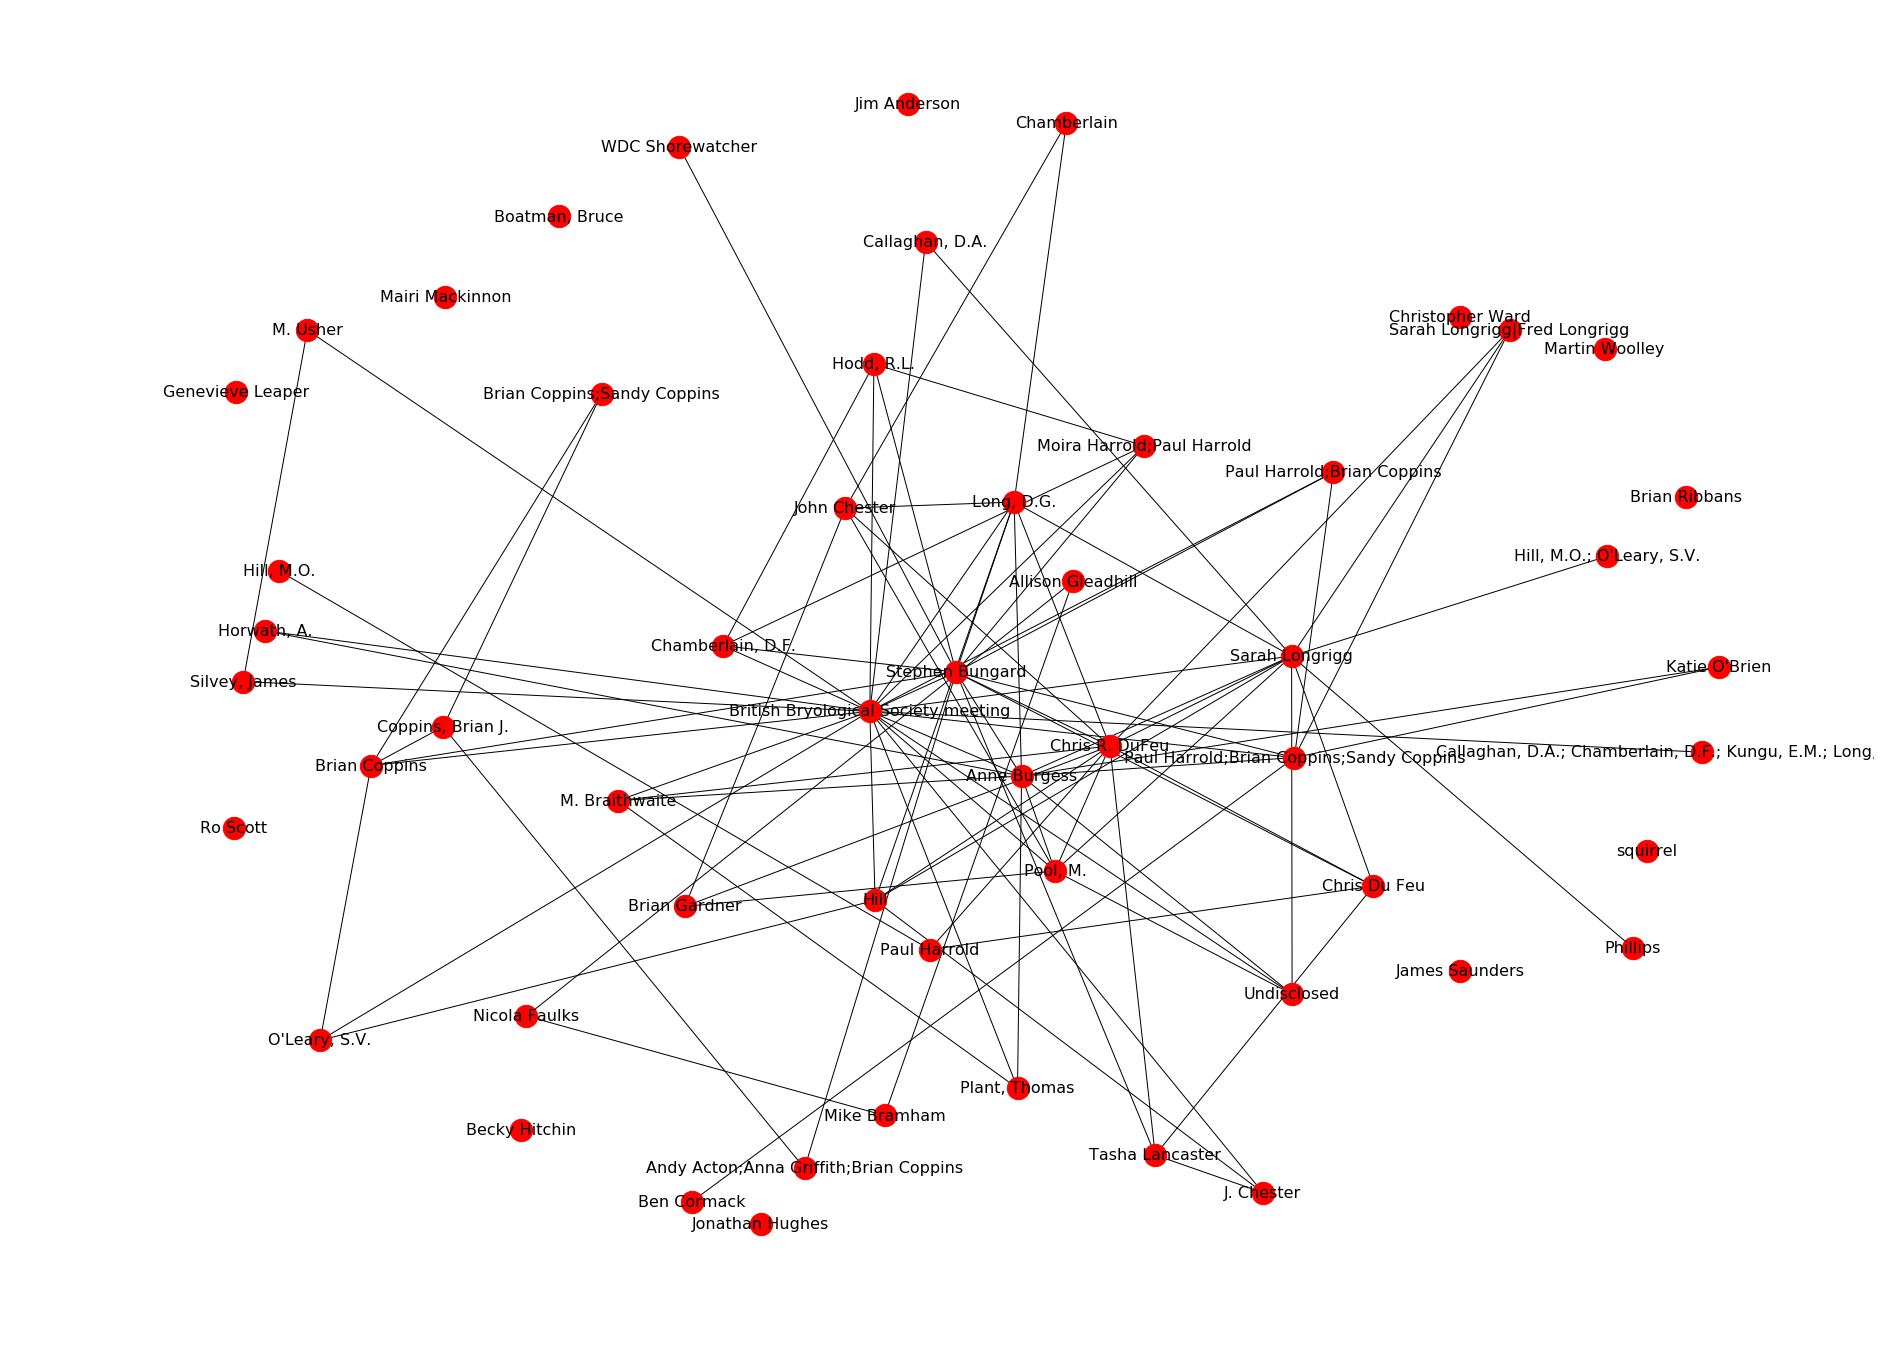

In [26]:
maxDist = 100 #anything within 100 metres observed is counted

def retrieveRecorders(df):
    return df['Recorder'].unique()

def retrieveRecorderLocations(df):
    recorders = retrieveRecorders(df)
    locs = {}
    for recorder in recorders:
        entries = df[df['Recorder'] == recorder]
        locations = zip(entries['Latitude (WGS84)'], entries['Longitude (WGS84)'])
        locations = set(locations)
        locs[recorder] = locations
    
    return locs

def recorderCloseTo(recorder, recorderLocs):
    currEntries = recorderLocs[recorder]
    remainder = recorderLocs.keys()
    ret = []
    for k,an in enumerate(remainder):
        if an != recorder:
            targetEntries = list(recorderLocs[an])
            breakYet = False
            for entry1 in currEntries:
                for entry2 in targetEntries:
                    if seperationInMetres(entry1,entry2) <= maxDist:
                        ret.append(k)
                        breakYet = True
                        break
                if breakYet:
                    break
    return ret

def buildGraph(df):    
    recorders = retrieveRecorders(df)
    
    G = nx.Graph()
    labels={}
    for k,i in enumerate(recorders): labels[k] = i
    
    for k,i in enumerate(recorders): G.add_node(k)
    recorderToLatLonMapping = retrieveRecorderLocations(df)
    for k,a in enumerate(recorders):
        closeTo = recorderCloseTo(a, recorderToLatLonMapping)
        for c in closeTo:
            G.add_edge(k,c)
    return G, labels


G, labels = buildGraph(df)
pos=nx.spring_layout(G,k=1)
nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G, pos, node_size=500)

In [27]:
len(list(filter(lambda x: x[0] == 22, list(G.edges()))))

0

In [28]:
labels

{0: 'John Chester',
 1: 'Jim Anderson',
 2: 'James Saunders',
 3: 'Chris R. DuFeu',
 4: 'Sarah Longrigg|Fred Longrigg',
 5: 'Undisclosed',
 6: 'M. Usher',
 7: 'Nicola Faulks',
 8: 'J. Chester',
 9: 'Sarah Longrigg',
 10: 'Allison Gleadhill',
 11: 'Brian Coppins',
 12: 'Andy Acton;Anna Griffith;Brian Coppins',
 13: 'Paul Harrold',
 14: 'Coppins, Brian J.',
 15: 'Paul Harrold;Brian Coppins;Sandy Coppins',
 16: 'Paul Harrold;Brian Coppins',
 17: 'Moira Harrold;Paul Harrold',
 18: 'Brian Coppins;Sandy Coppins',
 19: 'Mike Bramham',
 20: 'Ben Cormack',
 21: 'Boatman, Bruce',
 22: 'Mairi Mackinnon',
 23: 'Plant, Thomas',
 24: 'squirrel',
 25: 'Christopher Ward',
 26: 'Genevieve Leaper',
 27: 'Tasha Lancaster',
 28: 'Anne Burgess',
 29: 'Martin Woolley',
 30: 'WDC Shorewatcher',
 31: 'M. Braithwaite',
 32: 'Ro Scott',
 33: 'Becky Hitchin',
 34: 'Brian Ribbans',
 35: 'British Bryological Society meeting',
 36: 'Chamberlain, D.F.',
 37: 'Stephen Bungard',
 38: 'Pool, M.',
 39: 'Hill',
 40: 'Lon

In [8]:
file = nx.to_numpy_matrix(G)
print(file.shape)
print()
print(file)
np.savetxt("BasicSocialFile.txt",file, "%d")   

(55, 55)

[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


# Are the residents of Eigg linked to each other here? No :(

In [29]:
names = list(map(lambda x: x.lower(),inferredNamesGraph().keys()))
namedLinks = list(map(lambda x: (labels[x[0]].lower(),labels[x[1]].lower()),G.edges()))
for name in names:
    for nL in namedLinks:
        if name in nL[0] or name in nL[1]:
            print(nL, name)

('john chester', 'chris r. dufeu') john
('john chester', 'pool, m.') john
('john chester', 'long, d.g.') john
('john chester', 'chamberlain') john
('john chester', 'brian gardner') john


# Known observers before and since buyout

In [35]:
people = inferredNamesGraph()
observers = eiggRawData()

C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [37]:
#Exact Match
observers = observers.dropna(subset=['Recorder'])

preBuyout = observers[(observers['Start date year'] <= 1997.0) & (observers['Start date year'] > 1987.0)]
postBuyout = observers[(observers['Start date year'] > 1997.0) & (observers['Start date year'] <= 2007.0)]

preBuyout = preBuyout.dropna(subset=['Recorder'])
preBuyout = preBuyout["Recorder"]
preBuyout = list(preBuyout)
preBuyout = list(map(lambda x: x.lower(), preBuyout))

postBuyout = postBuyout.dropna(subset=['Recorder'])
postBuyout = postBuyout["Recorder"]
postBuyout = list(postBuyout)
postBuyout = list(map(lambda x: x.lower(), postBuyout))

people = list(map(lambda x: x.lower(), people))
people = list(filter(lambda x: ' ' in x, people))
people

['damian helliwell',
 'margaret fyffe',
 'norah barnes',
 'elizabeth boden',
 'lucy conway',
 'sarah boden',
 'mark alan foxwell',
 'grey carr',
 'jacqueline kirk',
 'ian leaver',
 'stuart mccarthy',
 'tasha mcvarish',
 'sue hollands',
 'neil robertson',
 'sue kirk',
 'alisdair kirk',
 'charlie galli',
 'libby galli',
 'eddie scott',
 'marie carr',
 'colin carr',
 'greg carr',
 'alex boden',
 'katrin bach',
 'tamsin mccarthy',
 'simon helliwell',
 'karen helliwell',
 'louise taylor',
 'martin merrick',
 'kenneth kean',
 'amanda moult',
 'annabelle scott-moncrieff',
 'laraine wyn-jones',
 'owain wyn-jones',
 'john christopher lynch',
 'john christopher clare',
 'john booth',
 'george carr',
 'saira renny',
 'bob wallace',
 'stuart millar',
 'jenny robertson',
 'donna mcculloch',
 'celia bull',
 'catherine davies',
 'pascal carr',
 'stuart fergusson',
 'peter wade-martins',
 'susanna wade-martins',
 'mairi mckinnon',
 'clare miller',
 'camille dressler',
 'hilda ibrahim',
 'ian alexander

In [11]:
len(postBuyout),len(preBuyout)

(10928, 3341)

In [47]:
def observationsByKnownPeople(people,observersList):
    total = 0
    knownPeople = []
    for o in observersList:
        for p in people:
            if p in o:
                knownPeople.append(p)
                total += 1
                break
    print(set(knownPeople))
    return (total / len(observersList))*100

In [48]:
print(observationsByKnownPeople(people,preBuyout))
print(observationsByKnownPeople(people,postBuyout))

set()
0.0
{'simon helliwell', 'marie carr', 'mairi mckinnon', 'alex boden', 'stuart millar', 'katrin bach', 'john booth', 'neil robertson', 'kenneth kean', 'stuart fergusson', 'pascal carr', 'colin carr', 'eddie scott'}
0.9791361639824305
